In [1]:
import os
import sys
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from glob import glob

In [2]:
from allensdk.brain_observatory.sync_dataset import Dataset
from allensdk.brain_observatory.ecephys.align_timestamps.barcode_sync_dataset import BarcodeSyncDataset
from allensdk.brain_observatory.ecephys.align_timestamps.channel_states import extract_barcodes_from_states, extract_splits_from_states
from allensdk.brain_observatory.ecephys.align_timestamps.barcode import match_barcodes

In [3]:
sys.path.append(r'C:\Users\lesliec\code')

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [5]:
%matplotlib notebook

### Load experiment

In [6]:
# data_folder = r"C:\Users\lesliec\data\EEG_exp\mouse521887\estimfull_2020-07-30\experiment1\recording2"
data_folder = r"E:\EEG_exp\mouse543393\test_ref_2020-08-17_13-55-22\experiment1\recording1"
pilotexp = EEGexp(data_folder, preprocess=False)

Experiment type: sensory stimulation.
SomnoSuite log file not found.


In [7]:
cont_dir = os.path.dirname(sorted(glob(data_folder + '/**/*continuous.dat', recursive=True))[0])
FPGA_name = os.path.basename(cont_dir)
print(FPGA_name)

Rhythm_FPGA-111.0


In [8]:
# memmap raw data to get size
datamm = pilotexp._memmap_EEGdata()
samp_rate = pilotexp.sample_rate
print(datamm.shape)
print(samp_rate)

Loading E:\EEG_exp\mouse543393\test_ref_2020-08-17_13-55-22\experiment1\recording1\continuous\Rhythm_FPGA-111.0\continuous.dat
(176128, 32)
2500


#### Get barcodes from sync file

In [9]:
print(pilotexp.sync_file)

E:\EEG_exp\mouse543393\test_ref_2020-08-17_13-55-22\experiment1\recording1\mouse543393200817135458.sync


In [10]:
# extract sync data
sync_dataset = BarcodeSyncDataset.factory(pilotexp.sync_file)
sync_times, sync_codes = sync_dataset.extract_barcodes()
sync_codes = np.array(sync_codes)

In [11]:
print('Sync times:')
print(sync_times[0:5])
print(np.shape(sync_times))
print('Sync barcodes:')
print(sync_codes[0:5])
print(np.shape(sync_codes))

Sync times:
[ 49.05661  79.99028 110.92393]
(3,)
Sync barcodes:
[1.41789125e+08 8.32798730e+07 1.03236885e+08]
(3,)


#### Get barcodes from EEG data stream

In [12]:
channel_states = np.load(os.path.join(pilotexp.data_folder, 'events', FPGA_name, 'TTL_1', 'channel_states.npy'))
timestamps = np.load(os.path.join(pilotexp.data_folder, 'events', FPGA_name, 'TTL_1', 'timestamps.npy'))

In [13]:
print(timestamps[0:5])
print(len(timestamps))
print(len(channel_states))

[554210 554260 554310 554382 554455]
26
26


##### Right now, the channel_states file reads -8, +8, -8...due to the barcodes being read in on digital line 8. Going to try dividing to make it 1s, because that is what the barcodes functions look for.

In [14]:
parsed_channel_states = {}
parsed_timestamps = {}
for i in range(1, 9):
    inds = np.argwhere((channel_states==i) | (channel_states==-i)).flatten()
    parsed_channel_states[str(i)] = channel_states[inds]/i
    parsed_timestamps[str(i)] = timestamps[inds]

In [15]:
eeg_barcode_times, eeg_barcodes = extract_barcodes_from_states(parsed_channel_states['8'], parsed_timestamps['8'], samp_rate)
eeg_split_times = extract_splits_from_states(parsed_channel_states['8'], parsed_timestamps['8'], samp_rate)
eeg_barcodes = np.array(eeg_barcodes)

In [16]:
print('EEG barcode times:')
print(eeg_barcode_times[0:5])
print(np.shape(eeg_barcode_times))
print('EEG_barcodes:')
print(eeg_barcodes[0:5])
print(np.shape(eeg_barcodes))
print(eeg_split_times)

EEG barcode times:
[252.618]
(1,)
EEG_barcodes:
[83279873.]
(1,)
[0]


In [17]:
for idx, split_time in enumerate(eeg_split_times):
    min_time = eeg_split_times[idx]

    if idx == (len(eeg_split_times) - 1):
        max_time = np.Inf
    else:
        max_time = eeg_split_times[idx+1]
    print('Split %d: begin %f , end %f' % (idx, min_time, max_time))

Split 0: begin 0.000000 , end inf


#### Need to take the timestamps from every barcode and find difference between each one. Is this diff constant for both?

<IPython.core.display.Javascript object>


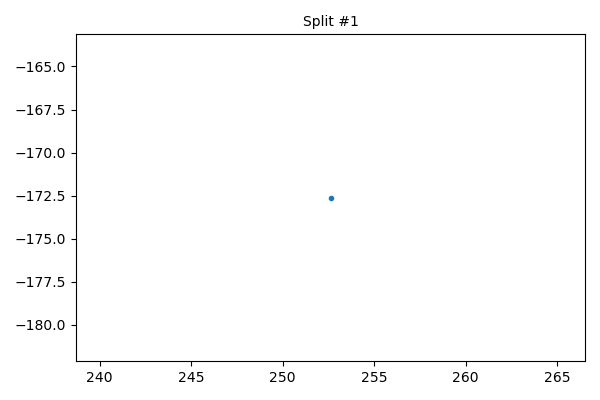

In [18]:
fig=plt.figure(figsize=(6,4))
subfignum = len(eeg_split_times)
for idx, split_time in enumerate(eeg_split_times):
    min_time = eeg_split_times[idx]

    if idx == (len(eeg_split_times) - 1):
        max_time = np.Inf
    else:
        max_time = eeg_split_times[idx+1]
        
    split_barcodes = eeg_barcodes[np.where((eeg_barcode_times > min_time) * (eeg_barcode_times < max_time))[0]]
    syncinds = np.isin(sync_codes, split_barcodes)
    eeginds = np.isin(eeg_barcodes, sync_codes[syncinds])
    overlapping_sync_times = sync_times[syncinds]
    overlapping_eeg_times = eeg_barcode_times[eeginds]
    
    ax=plt.subplot(1, subfignum, idx+1)
    ax.plot(overlapping_eeg_times, overlapping_sync_times - overlapping_eeg_times, '.')
    ax.set_title('Split #%d' % (idx+1))

fig.tight_layout()

### Need to align timestamps between each barcode.

In [19]:
origTS = np.load(os.path.join(pilotexp.data_folder, 'continuous', FPGA_name, 'timestamps.npy'))
print(origTS.shape)

(176128,)


In [20]:
print(datamm.shape[0])
print(origTS.shape[0])

176128
176128


##### Note: EEG timestamps do not begin at 0; they begin when the recording was started relative to starting OpenEphys.

### Need to loop through the eeg_split_times to align each section separately.
##### There shouldn't be any split times for the EEG recordings, but maybe safest to keep this in.

In [21]:
### What if the recording is short and there is only one barcode...?

aligned_timestamps = []
for idx, split_time in enumerate(eeg_split_times):
    if idx == 0: # in case the EEG timestamps do not begin at 0
        min_sample = origTS[idx]
        min_time = min_sample/samp_rate
    else:
        min_time = eeg_split_times[idx]
        min_sample = int(min_time*samp_rate)

    if idx == (len(eeg_split_times) - 1):
        max_sample = origTS[-1] # in case the EEG timestamps do not begin at 0
        max_time = max_sample/samp_rate
    else:
        max_time = eeg_split_times[idx+1]
        max_sample = int(max_time*samp_rate)
        
    # this finds the barcodes from this split that are common to the sync_ and eeg_barcodes
    split_barcodes = eeg_barcodes[np.where((eeg_barcode_times > min_time) * (eeg_barcode_times < max_time))[0]]
    syncinds = np.isin(sync_codes, split_barcodes)
    eeginds = np.isin(eeg_barcodes, sync_codes[syncinds])
    overlapping_sync_times = sync_times[syncinds]
    overlapping_eeg_times = eeg_barcode_times[eeginds]

    barcode_inds = (overlapping_eeg_times*samp_rate).astype('int64')
    
    if len(barcode_inds) == 1: # if there is only one common barcode
        match_barcode_mask = origTS == barcode_inds[0]
        origTS_sec = origTS/samp_rate
        ts_shift = origTS_sec[match_barcode_mask] - overlapping_sync_times[0]
        aligned_timestamps = origTS_sec - ts_shift
        
    else:
        xts = np.arange(barcode_inds[0], barcode_inds[-1]+1, 1)
        midts = np.interp(xts, barcode_inds, overlapping_sync_times)

        # fit a line to first/last 10 barcodes; this will error if # barcodes in split is less than 10
        n_fit = 2
        slope1, intercept1, r1, p1, stderr1 = st.linregress(overlapping_eeg_times[0:n_fit], overlapping_sync_times[0:n_fit])
        begts = np.arange(min_sample, barcode_inds[0])*(slope1/samp_rate) + intercept1

        slope2, intercept2, r2, p2, stderr2 = st.linregress(overlapping_eeg_times[-n_fit:], overlapping_sync_times[-n_fit:])
    #     endts = np.arange(barcode_inds[-1]+1, max_sample+1, 1)*(slope2/samp_rate) + intercept2 ## OLD method
        endts = np.arange(1, max_sample-barcode_inds[-1]+1, 1)*(slope2/samp_rate) + midts[-1] ## prevents timestamps from being equal?

        aligned_timestamps = np.concatenate((aligned_timestamps, begts, midts, endts))

In [22]:
print(len(aligned_timestamps))

176128


In [23]:
print(aligned_timestamps[0:10])

[23.05868 23.05908 23.05948 23.05988 23.06028 23.06068 23.06108 23.06148
 23.06188 23.06228]


#### Sanity check

In [24]:
if len(aligned_timestamps) == len(origTS):
    print('Wahooo, same length!')
else:
    print('Uh oh...?')

Wahooo, same length!


In [25]:
if (aligned_timestamps > 9000).sum() == 0:
    print('All looks good, no crazy high timestamps')
else:
    print((aligned_timestamps > 9000).sum())

All looks good, no crazy high timestamps


In [26]:
if np.all(aligned_timestamps[1:] >= aligned_timestamps[:-1], axis=0): # should be TRUE!!! for only-increasing arrays (like timestamps should be)
    print('Good to go, timestamps are only increasing')

Good to go, timestamps are only increasing


In [27]:
if np.any(aligned_timestamps[:-1] >= aligned_timestamps[1:], axis=0): # should be TRUE!!! for only-increasing arrays (like timestamps should be)
    print('Aligned timestamps are not increasing.')

### Check offsets now

<IPython.core.display.Javascript object>


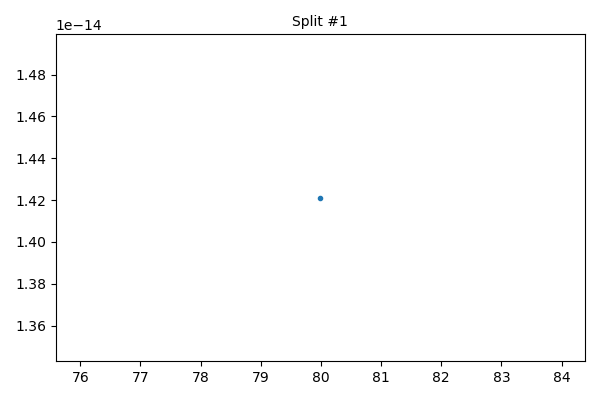

In [29]:
fig=plt.figure(figsize=(6,4))
subfignum = len(eeg_split_times)
for idx, split_time in enumerate(eeg_split_times):
    min_time = eeg_split_times[idx]

    if idx == (len(eeg_split_times) - 1):
        max_time = np.Inf
    else:
        max_time = eeg_split_times[idx+1]
        
    split_barcodes = np.array(eeg_barcodes)[np.where((eeg_barcode_times > min_time) * (eeg_barcode_times < max_time))[0]]
    syncinds = np.isin(sync_codes, split_barcodes)
    eeginds = np.isin(eeg_barcodes, sync_codes[syncinds])
    overlapping_sync_times = sync_times[syncinds]
    overlapping_eeg_times = eeg_barcode_times[eeginds]
    new_eeg_times = aligned_timestamps[(overlapping_eeg_times*samp_rate).astype('int64') - origTS[0]]
    # something is wrong with above line...
    
    ax=plt.subplot(1,subfignum,idx+1)
    ax.plot(new_eeg_times,overlapping_sync_times-new_eeg_times,'.')
    ax.set_title('Split #%d' % (idx+1))

fig.tight_layout()

#### All looks good, now save.

In [31]:
np.save(os.path.join(pilotexp.data_folder, 'continuous', FPGA_name, 'timestamps_master_clock.npy'), aligned_timestamps, allow_pickle=False)